In [108]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from time import time

In [109]:
def true_sol(x: float):
    return x + np.exp(1) / (1 - np.exp(2)) * (np.exp(x) - np.exp(-x))

In [110]:
def solve_naive(n: int = 1000, n_max: int = 1000):
    t_start = time()
    h = 1 / (n + 1)
    b = np.arange(1, n + 1) * h
    if n > n_max + 1:
        D = scipy.sparse.identity(n).multiply(2 * np.power(h, -2) + 1)
        Doff = scipy.sparse.eye(n, k=1).multiply(-np.power(h, -2))
        A = D + Doff + Doff.T
        sol = scipy.sparse.linalg.spsolve(A, b)
    else:
        D = np.eye(n) * (2 * np.power(h, -2) + 1)
        Doff = np.eye(n, k=1) * (-np.power(h, -2))
        A = D + Doff + Doff.T
        sol = np.linalg.solve(A, b)
    return b, sol, time() - t_start

def solve_thomas_v1(A: np.ndarray, d: list):
    def a_(i):
        return A[i - 1][i - 2]

    def b_(i):
        return A[i - 1][i - 1]

    def c_(i):
        return A[i - 1][i]

    def d_(i):
        return d[i - 1]
    
    t_start = time()
    n = d.shape[0]
    alphas = np.zeros(n - 1)
    betas = np.zeros(n)
    alphas[0] = c_(1) / b_(1)
    betas[0] = d_(1) / b_(1)
    for i in range(2, n + 1):
        if i <= n - 1:
            alphas[i - 1] = c_(i) / (b_(i) - a_(i) * alphas[i - 2])
        betas[i - 1] = (d_(i) - a_(i) * betas[i - 2]) / (b_(i) - a_(i) * alphas[i - 2])
    
    sol = np.zeros(n)
    for i in range(n, 0, -1):
        if i == n:
            sol[i - 1] = betas[i - 1]
        else:
            sol[i - 1] = betas[i - 1] - alphas[i - 1] * sol[i]

    return sol, time() - t_start


def solve_thomas_v2(b: float, c: float, d: list):
    t_start = time()
    n = d.shape[0]
    a = c

    alphas = np.zeros(n - 1)
    betas = np.zeros(n)
    alphas[0] = c / b
    betas[0] = d[0] / b
    for i in range(2, n + 1):
        if i <= n - 1:
            alphas[i - 1] = c / (b - a * alphas[i - 2])
        betas[i - 1] = (d[i - 1] - a * betas[i - 2]) / (b - a * alphas[i - 2])

    sol = np.zeros(n)
    for i in range(n, 0, -1):
        if i == n:
            sol[i - 1] = betas[i - 1]
        else:
            sol[i - 1] = betas[i - 1] - alphas[i - 1] * sol[i]

    return sol, time() - t_start

In [111]:
# Here we check correctness of numerical solution
n = 1000
h = 1 / (n + 1)
b = np.arange(1, n + 1) * h
D = np.eye(n) * (2 * np.power(h, -2) + 1)
Doff = np.eye(n, k=1) * (-np.power(h, -2))
A = D + Doff + Doff.T

_, ans1, _ = solve_naive(n)
ans2, _ = solve_thomas_v1(A, b)
ans3, _ = solve_thomas_v2(A[0][0], A[0][1], b)

true_ans = true_sol(b)

print("|ans* - true_ans|, where ans* and true_ans are vectors")
print("SLE:", np.linalg.norm(ans1 - true_ans), "\nThomas v1:", np.linalg.norm(ans2 - true_ans), "\nThomas v2:", np.linalg.norm(ans3 - true_ans))

|ans* - true_ans|, where ans* and true_ans are vectors
SLE: 1.00090116488041e-07 
Thomas v1: 1.0008994371336786e-07 
Thomas v2: 1.0008994371336786e-07


Из наивного сравнения по модулю вектора разности $\hat{\vec{x}} - \vec{x}_0$, где $\hat{\vec{x}}$ --- вектор какого-то численного решение на интервале, а $\vec{x}_0$ --- вектор значений аналитического решения на том же интервале. Можно сделать вывод, что в целом реализации численных методо корректны.

In [112]:

def prep_to_plot_naive(n: int, n_max: int = 1000, step: int = 1):
    times = []
    diffs = []
    for i in range(1, n + step, step):
        x, ans, time_spent = solve_naive(i, n_max=n_max)
        true_ans = true_sol(x)
        diffs.append(np.linalg.norm(ans - true_ans))
        times.append(time_spent)
    return list(range(1, n + step, step)), times, diffs

def prep_to_plot_thomas(n: int, step: int = 1):
    times_thomas_v1 = []
    diffs_thomas_v1 = []
    times_thomas_v2 = []
    diffs_thomas_v2 = []
    for i in range(2, n + step, step):
        h = 1 / (i + 1)
        b = np.arange(1, i + 1) * h
        D = np.eye(i) * (2 * np.power(h, -2) + 1)
        Doff = np.eye(i, k=1) * (-np.power(h, -2))
        A = D + Doff + Doff.T
        ans1, time_spent1 = solve_thomas_v1(A, b)
        ans2, time_spent2 = solve_thomas_v2(A[0][0], A[0][1], b)
        true_ans = true_sol(b)
        times_thomas_v1.append(time_spent1)
        times_thomas_v2.append(time_spent2)
        diffs_thomas_v1.append(np.linalg.norm(ans1 - true_ans))
        diffs_thomas_v2.append(np.linalg.norm(ans2 - true_ans))
    return list(range(1, n + step, step)), times_thomas_v1, diffs_thomas_v1, times_thomas_v2, diffs_thomas_v2



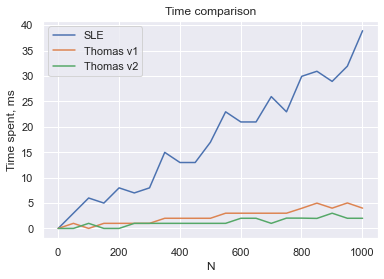

In [113]:
n = 1000
step = 50
data_naive = prep_to_plot_naive(n, step=step)
data_thomas = prep_to_plot_thomas(n, step)
sns.set()
plt.plot(data_naive[0], [time*1000 for time in data_naive[1]], label="SLE")
plt.plot(data_thomas[0], [time*1000 for time in data_thomas[1]], label="Thomas v1")
plt.plot(data_thomas[0], [time*1000 for time in data_thomas[3]], label="Thomas v2")
plt.xlabel("N")
plt.ylabel("Time spent, ms")
plt.title("Time comparison")
plt.legend()
plt.show()

Из полученного графика видно, что наивное решение пусть и встроенным оптимизированным методом numpy для целой СЛАУ сильно проигрывает во времени, по сравнению с методом прогонки, реализация которой, наверняка, не особо и оптимизирована. Стоит отметить отдельно, что вторая реализация специфична для симметричных матриц A.

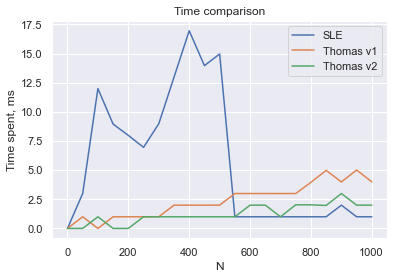

In [114]:
n = 1000
n_max = 500
step = 50
data_naive = prep_to_plot_naive(n, n_max=n_max, step=step)
plt.plot(data_naive[0], [time*1000 for time in data_naive[1]], label="SLE")
plt.plot(data_thomas[0], [time*1000 for time in data_thomas[1]], label="Thomas v1")
plt.plot(data_thomas[0], [time*1000 for time in data_thomas[3]], label="Thomas v2")
plt.xlabel("N")
plt.ylabel("Time spent, ms")
plt.title("Time comparison")
plt.legend()
plt.show()

На данном графике видно, но при переходе к разреженным матрицам (в данном примере переход осуществляется при линейном размере матрицы $A > 500$) и, соответственно, к оптимизированным методам решения СЛАУ для них, мы получаем время работы, которое даже чуть-чуть лучше, чем метод прогонки (можно списать на неоптимизированный код для реализованного метода прогонки)